# Halvorsen attractor Model

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint, solve_ivp
from sklearn.linear_model import Lasso
import pysindy as ps

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

### Define Halvorsen equations to produce training data:

In [3]:
alpha = 2

In [4]:
def halvorsen(t, x):
    return [
        -alpha*x[0] -4*x[1] -4*x[2] -x[1]**2,
        -alpha*x[1] -4*x[2] -4*x[0] -x[2]**2,
        -alpha*x[2] -4*x[0] -4*x[1] -x[0]**2 
    ]

### Create training data (2 Trajectories):

In [5]:
dt = 0.001  # Timestep

# First trajectory:
t_train1 = np.arange(0,10,dt)  # Time range to integrate over
x0_train1 = [-1,1,-1]  # Initial conditions
sol1 = solve_ivp(halvorsen, (t_train1[0], t_train1[-1]), x0_train1, t_eval=t_train1)  # Integrate to produce x(t),y(t),z(t)
x_train1 = np.transpose(sol1.y)  
print(x_train1)

# Second trajectory:
t_train2 = np.arange(100,110,dt)  # Time range to integrate over
x0_train2 = [2,-2,2]  # Initial conditions
sol2 = solve_ivp(halvorsen, (t_train2[0], t_train2[-1]), x0_train2, t_eval=t_train2) # Integrate to produce x(t),y(t),z(t)
x_train2 = np.transpose(sol2.y)  

# Add noise to both our trajectories:
x_train1 += np.random.normal(scale = 0.05, size=x_train1.shape) 
x_train2 += np.random.normal(scale = 0.05, size=x_train2.shape) 

# Combine both trajectory data sets into a list:
x_train = [x_train1, x_train2]

[[-1.          1.         -1.        ]
 [-0.99801889  1.00398808 -0.99801293]
 [-0.99607536  1.00795251 -0.99605155]
 ...
 [ 3.13123781 -8.3059492  -5.43255443]
 [ 3.10783436 -8.30115657 -5.40528322]
 [ 3.08443978 -8.29614556 -5.37788388]]


### Create our SINDy model:

In [6]:
stlsq_opt = ps.STLSQ(threshold = 0.1)
model = ps.SINDy(optimizer=stlsq_opt)
model.fit(x_train, t=dt, multiple_trajectories=True)
model.print()

x0' = -3.021 x0 + -4.015 x1 + -4.008 x2 + -1.001 x1^2
x1' = -4.025 x0 + -3.029 x1 + -4.039 x2 + -1.004 x2^2
x2' = -4.035 x0 + -4.021 x1 + -3.021 x2 + -1.004 x0^2



### Assess results on a test trajectory:

In [8]:
# Evolve the Halvorsen equations in time using a different initial condition
t_test = np.arange(0, 15, dt)  # Longer time range
x0_test = np.array([3, -4, -1.3])  # New initial conditions
sol = solve_ivp(halvorsen, (t_test[0], t_test[-1]), x0_test, t_eval=t_test) # Integrate to produce x(t),y(t),z(t)
x_test = np.transpose(sol.y)  

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.999688


### Simulate forward in time:

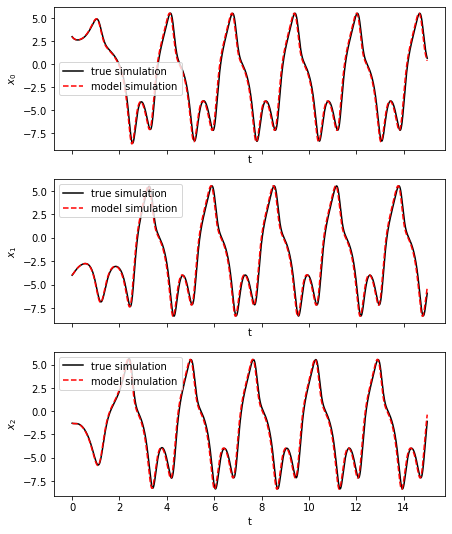

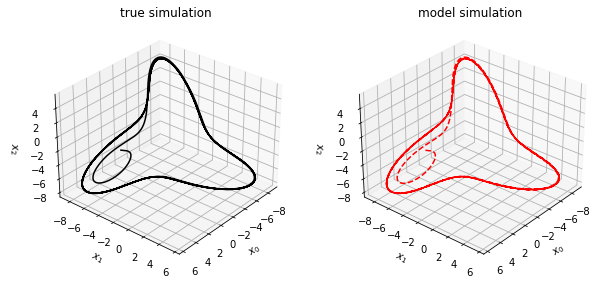

In [9]:
x_test_sim = model.simulate(x0_test, t_test)
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7,9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))
    #plt.xlim([290,300])
    
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')
ax1.view_init(30,40)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], x_test_sim[:, 2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')
ax2.view_init(30,40)